In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 08 - Simple Neural Network with Fibonacci 

### v0

by Louis Yang

Recheck the peformance of model 04 with the grouping and Fibonacci median

Use Fibonacci series median instead of median

Split into groups based on the scale of visit number and train individual model in each group

The first 2 groups use original Fibonacci median as prediction. The rest groups use the trained ANN as prediction.

Modified from the "model_7_CNN_with_Fibonacci_2_Mix"

Result: 

In [2]:
model_name = 'model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

In [4]:
def arr_info(arr_list):
    print('shape, min, max, median, stdev')
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

## Input

In [5]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


input_df.head()

input_df.info()

In [6]:
input_df_dates = input_df.columns[1:]; #input_df_dates

input_data = input_df[input_df_dates].values; input_data

## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [7]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [8]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [9]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [10]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [11]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-08-30', '2015-10-31')

In [12]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [13]:
# X for output set
if test_length:
    print('Testing')
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    print('Predicting')
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

Testing


In [14]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-08-28', '2016-10-29')

In [15]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [16]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

#### Y

In [17]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [18]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2015-11-01', '2016-01-02')

In [19]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [20]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-01-01'
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [21]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2016-10-30', '2016-12-31')

In [22]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [23]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

## Fibonacci

In this testing code, we should not include the last y_length days since in the real predicting stage, we don't know their visits.

Here, we don't distinguish between input and output fib_dates.

In [24]:
if test_length:
    fib_dates = input_df_dates[:-test_length]
else:
    fib_dates = input_df_dates
fib_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-10-20', '2016-10-21', '2016-10-22', '2016-10-23', '2016-10-24',
       '2016-10-25', '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29'],
      dtype='object', length=487)

In [25]:
fib_data = input_df[fib_dates].values; fib_data

array([[ 18.,  11.,   5., ...,  20.,  12.,  19.],
       [ 11.,  14.,  15., ...,  21.,  27.,  33.],
       [  1.,   0.,   1., ...,   3.,   3.,   2.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

### Find starting dates

Not using this. Use numpy nan method instead

start_tf = ~np.isnan(fib_data); start_tf

fib_days = len(fib_data[0]); fib_days

index_range = np.arange(fib_days)
def first_true_index(x):
    temp = index_range[x]
    if temp.any():
        return temp[0]
    else:
        return -1
#first_true_index_v = np.vectorize(first_true_index)

start_index = np.array([first_true_index(x) for x in start_tf])

start_index

### Window

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [26]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]

In [27]:
fib_view_list = [fib_data[:, -w:] for w in windows]

In [28]:
fib_median_list = np.array([np.nanmedian(view, axis=-1) 
                            for view in fib_view_list])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [29]:
fib_median_list.T.shape

(145063, 8)

In [30]:
fib_median_na = np.nanmedian(fib_median_list.T, axis=-1)

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_median_na

In [31]:
fib_median = np.nan_to_num(fib_median_na); fib_median.shape

(145063,)

In [32]:
fib_median

array([ 18.  ,  25.25,   4.  , ...,   0.  ,   0.  ,   0.  ])

We will use this as the center and part of the result

In [33]:
Y_output_fib = fib_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input data

In [34]:
X_input_first_day, Y_input_final_day

('2015-08-30', '2016-01-02')

input_data contains X_input and Y_input array

In [35]:
input_dates = pd.Index(np.concatenate((X_input_dates, Y_input_dates)))
input_dates

Index(['2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
       '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08',
       ...
       '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
       '2015-12-29', '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02'],
      dtype='object', length=126)

In [36]:
input_data = input_df[input_dates].values; input_data

array([[  9.,  10.,   9., ...,  18.,   9.,  16.],
       [ 22.,  11.,  81., ...,   9.,   7.,  15.],
       [  1.,   3.,   4., ...,   2.,   2.,   0.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

##### Convert nan to number 0.

In [37]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[  9.,  10.,   9., ...,  18.,   9.,  16.],
       [ 22.,  11.,  81., ...,   9.,   7.,  15.],
       [  1.,   3.,   4., ...,   2.,   2.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [38]:
input_data_num.shape

(145063, 126)

### Output Data

In [39]:
X_output_first_day, X_output_final_day, Y_output_final_day

('2016-08-28', '2016-10-29', '2016-12-31')

output_data for this self-testing script contains both X_output and Y_output

In [40]:
if test_length:
    output_dates = pd.Index(np.concatenate((X_output_dates, Y_output_dates)))
else:
    output_dates = X_output_dates
output_dates

Index(['2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01',
       '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=126)

In [41]:
output_dates.shape

(126,)

In [42]:
output_data = input_df[output_dates].values; output_data

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

##### Convert nan to number 0.

In [43]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [44]:
output_data_num.shape

(145063, 126)

### View

In [45]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

examine(input_data)

## Transform Data

### Log

In [46]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [47]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [48]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [49]:
output_data_log.shape, output_data.shape

((145063, 126), (145063, 126))

input_data_log

output_data_log

#Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

#Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

del input_data_log_tt
del input_data_log_tt_dif
del output_data_log_tt
del output_data_log_tt_dif

In [50]:
gc.collect()

0

### Normalization (Shift and Scale)

#### Use Fib Median as the Center

In [51]:
input_center = log(fib_median).reshape(-1,1)
output_center = log(fib_median).reshape(-1,1)

In [52]:
input_center

array([[ 1.2787536 ],
       [ 1.41912931],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

#### Compute Median and Stdev

Here we are not using this median

In [53]:
np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)

array([[ 1.04139269],
       [ 1.23044892],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

In [54]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.22974401],
       [ 0.23685744],
       [ 0.27363311],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

In [55]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.19725496],
       [ 0.25052371],
       [ 0.21878369],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [56]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [57]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [58]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

#Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

#Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

del input_data_norm_it
del input_data_norm_it_dif
del output_data_norm_it
del output_data_norm_it_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

#### Input Center

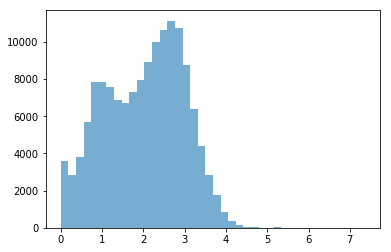

In [59]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.show()

plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Center

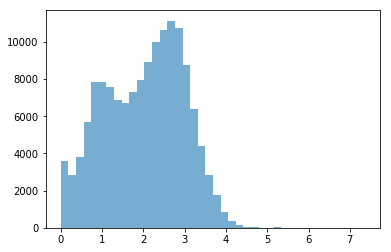

In [60]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.show()

plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input Scale

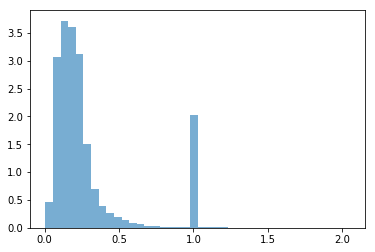

In [61]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output Scale

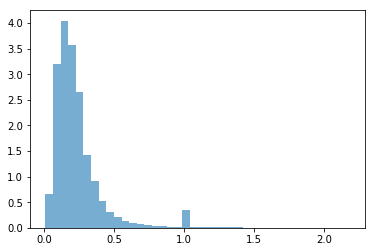

In [62]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [63]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

[0, 1, 2, 3, 4, 5]

In [64]:
input_gp = group_index_v(input_center).reshape(-1)
output_gp = group_index_v(output_center).reshape(-1)
input_gp, output_gp

(array([2, 2, 1, ..., 0, 0, 0]), array([2, 2, 1, ..., 0, 0, 0]))

In [65]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[3422, 23105, 40264, 77416, 790, 66]

In [66]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[3422, 23105, 40264, 77416, 790, 66]

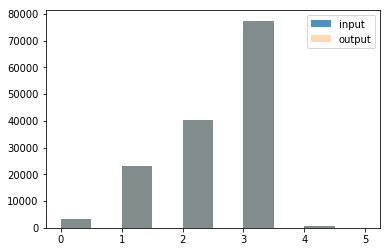

In [67]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

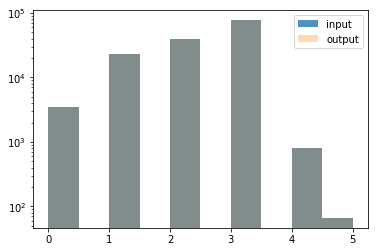

In [68]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [69]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [70]:
X_output = output_data_norm[:, :x_length]
if test_length:
    Y_output = output_data_norm[:, -y_length:]
    print(X_output.shape, Y_output.shape)
else:
    print(X_output.shape, 'No Y_output')

(145063, 63) (145063, 63)


#### Original data

In [71]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
if test_length: 
    Y_output_ori = output_data_num[:, -y_length:] 

#### Raw data (with nan)

In [72]:
X_input_raw = input_data[:, :x_length]
Y_input_raw = input_data[:, -y_length:]
X_output_raw = output_data[:, :x_length]
if test_length:
    Y_output_raw = output_data[:, -y_length:]

#### Backward compatible

In [73]:
X_train = X_input
Y_train = Y_input
X_val = X_output
if test_length:
    Y_val = Y_output

In [74]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
if test_length:
    Y_val_ori = Y_output_ori

In [75]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_center

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

if test_length:
    print(Y_output)
    print(output_data_norm[:,-y_length:])

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

if test_length:
    print(Y_output_ori)
    print(output_data_num)

if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

#### Min and max cases examination

np.argmax(Y_input, axis=0)

Y_input[34790]

Y_input_ori[34790]

fib_median[34790]

log(Y_input_ori[34790])

log(fib_median[34790])

np.std(log(Y_input_ori[34790]))

np.std(log(X_input_ori[34790]))

input_scale[34790]

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [76]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [77]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [78]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [79]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.nanmean(diff, axis=axis)

def smape_CPMP(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error suggested by CPMP'''
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff, axis=axis)

In [80]:
smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

(200.0, 0.0)

smape_CPMP(np.array([0,1]),np.array([np.nan, 0])), smape_CPMP(np.array([0]),np.array([0]))

#Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

In [81]:
# Benchmark SMAPE on the original data
smape(Y_input_raw[:,:x_length],X_input_ori[:,-y_length:]), smape(Y_input_ori[:,:x_length],X_input_ori[:,-y_length:])

(56.816030253680275, 51.874930937113326)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [158]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D

In [159]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Dense(120, activation='relu')(layer_0)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 63)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 120)               7680      
_________________________________________________________________
dense_26 (Dense)             (None, 120)               14520     
_________________________________________________________________
dropout_13 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 120)               14520     
_________________________________________________________________
dropout_14 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 63)                7623      
T

#CNN
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(120, kernel_size=5, activation='relu')(layer_t)
    layer_t = MaxPooling1D(pool_size=2)(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

In [160]:
len(gp_list)

6

In [161]:
epochs_list = [40,40,40,40,60,80]

In [162]:
%%time
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    print('Group:',gp)
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05, verbose=2)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Group: 0
Train on 3250 samples, validate on 172 samples
Epoch 1/40
1s - loss: 1.5418 - k_smape: 191.1463 - val_loss: 0.0626 - val_k_smape: 198.8744
Epoch 2/40
0s - loss: 1.2692 - k_smape: 195.0135 - val_loss: 0.0366 - val_k_smape: 198.5240
Epoch 3/40
0s - loss: 1.0717 - k_smape: 194.4945 - val_loss: 0.0419 - val_k_smape: 198.6713
Epoch 4/40
0s - loss: 1.0639 - k_smape: 194.6027 - val_loss: 0.0586 - val_k_smape: 198.8922
Epoch 5/40
0s - loss: 1.1421 - k_smape: 194.8308 - val_loss: 0.0440 - val_k_smape: 198.6540
Epoch 6/40
0s - loss: 0.9763 - k_smape: 194.2466 - val_loss: 0.0483 - val_k_smape: 198.7207
Epoch 7/40
0s - loss: 0.8897 - k_smape: 193.9827 - val_loss: 0.0295 - val_k_smape: 198.4113
Epoch 8/40
0s - loss: 0.8707 - k_smape: 193.6937 - val_loss: 0.0320 - val_k_smape: 198.5524
Epoch 9/40
0s - loss: 0.9324 - k_smape: 194.0762 - val_loss: 0.0380 - val_k_smape: 198.6235
Epoch 10/40
0s - loss: 0.8342 - k_smape: 193.6150 - val_loss: 0.0322 - val_k_smape: 198.5251
Epoch 11/40
0s - loss: 

1s - loss: 2.4600 - k_smape: 112.9287 - val_loss: 1.1407 - val_k_smape: 134.5231
Epoch 9/40
1s - loss: 2.5131 - k_smape: 113.4154 - val_loss: 1.1292 - val_k_smape: 136.1727
Epoch 10/40
1s - loss: 2.3734 - k_smape: 111.9439 - val_loss: 1.1492 - val_k_smape: 133.6364
Epoch 11/40
1s - loss: 2.3832 - k_smape: 112.2408 - val_loss: 1.1300 - val_k_smape: 132.1378
Epoch 12/40
1s - loss: 2.3525 - k_smape: 111.1845 - val_loss: 1.1146 - val_k_smape: 133.8829
Epoch 13/40
1s - loss: 2.4539 - k_smape: 111.4550 - val_loss: 1.1318 - val_k_smape: 134.8995
Epoch 14/40
1s - loss: 2.3843 - k_smape: 110.8470 - val_loss: 1.1221 - val_k_smape: 130.5907
Epoch 15/40
1s - loss: 2.3475 - k_smape: 110.4586 - val_loss: 1.1279 - val_k_smape: 133.9116
Epoch 16/40
1s - loss: 2.3163 - k_smape: 110.7291 - val_loss: 1.1586 - val_k_smape: 140.5655
Epoch 17/40
1s - loss: 2.2917 - k_smape: 111.3965 - val_loss: 1.1566 - val_k_smape: 135.5781
Epoch 18/40
1s - loss: 2.3350 - k_smape: 110.8616 - val_loss: 1.1744 - val_k_smape:

0s - loss: 8.3089 - k_smape: 95.3641 - val_loss: 45.7265 - val_k_smape: 88.9181
Epoch 24/60
0s - loss: 8.2948 - k_smape: 95.8767 - val_loss: 38.6724 - val_k_smape: 88.2279
Epoch 25/60
0s - loss: 7.8567 - k_smape: 93.9512 - val_loss: 30.7058 - val_k_smape: 85.8580
Epoch 26/60
0s - loss: 9.2210 - k_smape: 93.7471 - val_loss: 47.6168 - val_k_smape: 89.1120
Epoch 27/60
0s - loss: 9.2688 - k_smape: 95.1591 - val_loss: 59.4592 - val_k_smape: 91.3807
Epoch 28/60
0s - loss: 7.6945 - k_smape: 92.3631 - val_loss: 21.5489 - val_k_smape: 85.1545
Epoch 29/60
0s - loss: 8.0889 - k_smape: 91.5411 - val_loss: 31.2786 - val_k_smape: 87.0967
Epoch 30/60
0s - loss: 9.1942 - k_smape: 92.7818 - val_loss: 58.3195 - val_k_smape: 90.4359
Epoch 31/60
0s - loss: 7.1790 - k_smape: 92.1958 - val_loss: 20.5788 - val_k_smape: 84.7200
Epoch 32/60
0s - loss: 7.2945 - k_smape: 89.5368 - val_loss: 30.5120 - val_k_smape: 87.3523
Epoch 33/60
0s - loss: 8.6231 - k_smape: 90.2751 - val_loss: 58.4252 - val_k_smape: 90.1433


### Training History

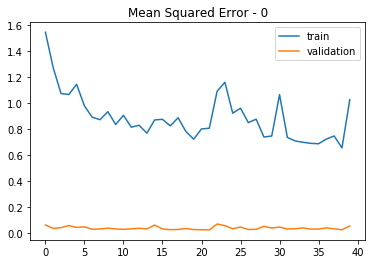

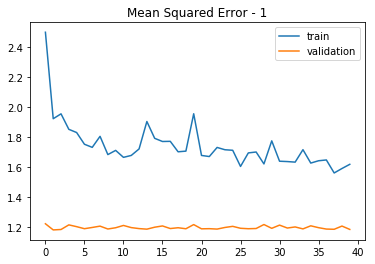

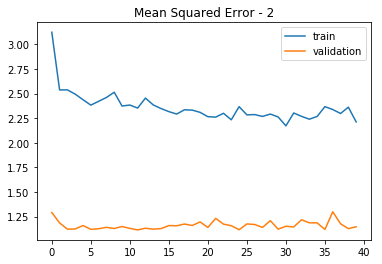

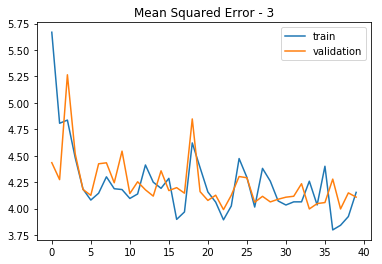

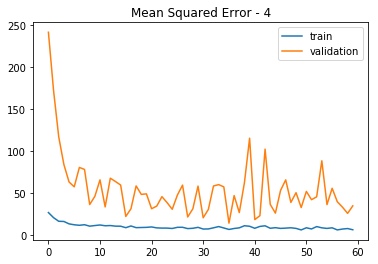

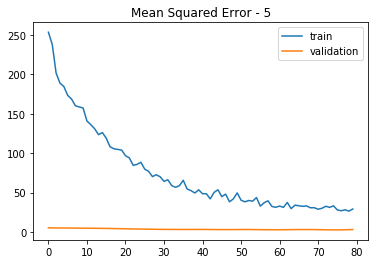

In [163]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

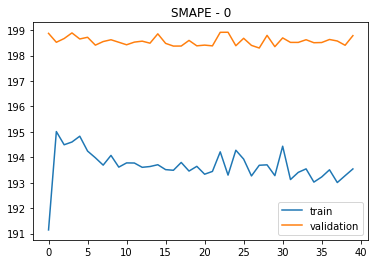

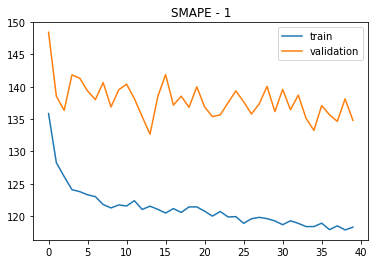

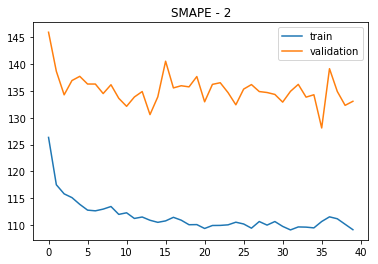

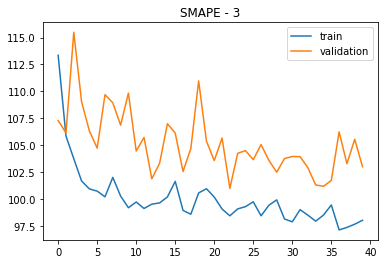

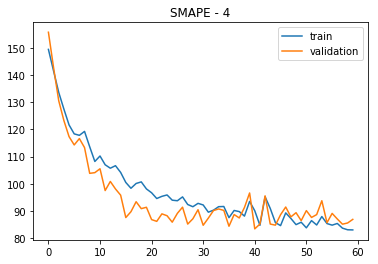

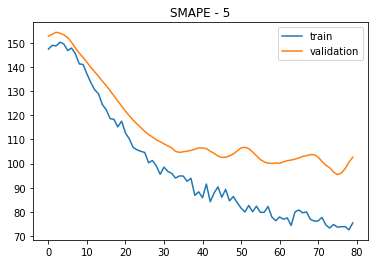

In [164]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

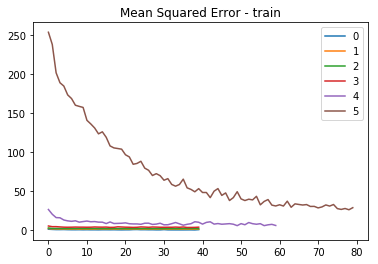

In [165]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

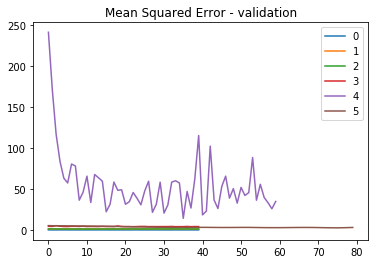

In [166]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

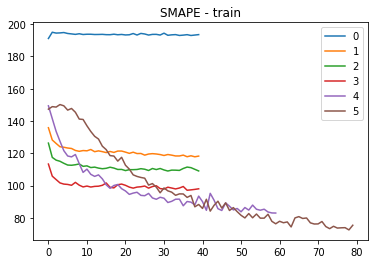

In [167]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

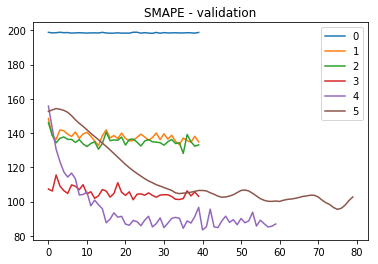

In [168]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### Evaluation using for Output Set

In [169]:
if test_length:
    for (gp, model, X, Y) in zip(gp_list, models, 
                                 X_output_list, Y_output_list):
        print()
        print(model.evaluate(X,Y))


2688/3422 [======================>.......] - ETA: 0s[10.780508894663825, 192.57898380852527]

22848/23105 [============================>.] - ETA: 0s[4.568981155371981, 158.6233859608891]

39264/40264 [============================>.] - ETA: 0s[3.0558249386219529, 145.85898059380355]

77024/77416 [============================>.] - ETA: 0s[3.6666986996740474, 133.06733436974733]

 32/790 [>.............................] - ETA: 0s[3.1129021053072772, 132.72269391409958]

32/66 [=============>................] - ETA: 0s[14.914170821507772, 136.19925944010416]


### Predict for Output Set

In [170]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4
5


Find the original index

In [171]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [172]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [173]:
for o in output_index_list:
    print(o.shape)

(3422,)
(23105,)
(40264,)
(77416,)
(790,)
(66,)


In [174]:
output_index_list_comb = np.concatenate(output_index_list)
output_index_list_comb

array([    52,     81,    117, ..., 131296, 139119, 140151])

In [175]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [176]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [177]:
# Inverse transform Y of output
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

#### Check predict output

In [178]:
Y_output_pred

array([[-0.0925954 , -0.02208254,  0.009987  , ..., -0.06530219,
         0.04361644,  0.2378698 ],
       [ 0.06066796, -0.08473629, -0.08979294, ...,  0.02134141,
         0.26496422,  0.41650215],
       [-0.26811966, -0.24433126, -0.13169682, ...,  0.01666994,
        -0.10388498,  0.1001104 ],
       ..., 
       [ 0.01631301,  0.00895645,  0.02589227, ...,  0.04238625,
         0.04334038,  0.06820592],
       [ 0.01631301,  0.00895645,  0.02589227, ...,  0.04238626,
         0.04334038,  0.06820592],
       [ 0.01631301,  0.00895645,  0.02589227, ...,  0.04238626,
         0.04334038,  0.06820592]], dtype=float32)

In [179]:
Y_output_pred_ori

array([[  1.72174967e+01,   1.78103861e+01,   1.80863809e+01, ...,
          1.74447350e+01,   1.83801512e+01,   2.01677452e+01],
       [  2.61849207e+01,   2.39977464e+01,   2.39249358e+01, ...,
          2.55751569e+01,   2.95850454e+01,   3.23789732e+01],
       [  3.36827323e+00,   3.42093684e+00,   3.67904140e+00, ...,
          4.04216573e+00,   3.74505953e+00,   4.25862893e+00],
       ..., 
       [  3.82764630e-02,   2.08371138e-02,   6.14322164e-02, ...,
          1.02519431e-01,   1.04944288e-01,   1.70054046e-01],
       [  3.82764630e-02,   2.08371138e-02,   6.14322164e-02, ...,
          1.02519441e-01,   1.04944288e-01,   1.70054046e-01],
       [  3.82764630e-02,   2.08371138e-02,   6.14322164e-02, ...,
          1.02519441e-01,   1.04944288e-01,   1.70054046e-01]])

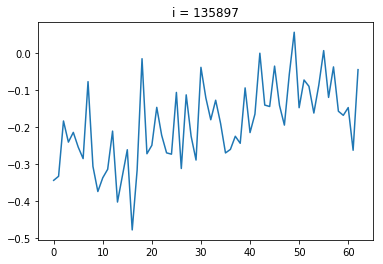

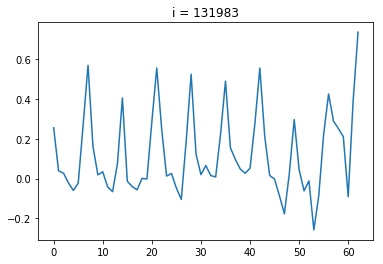

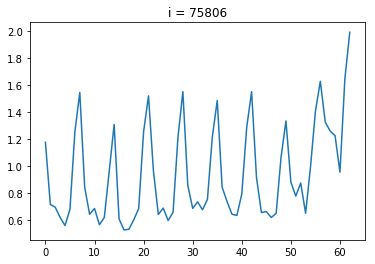

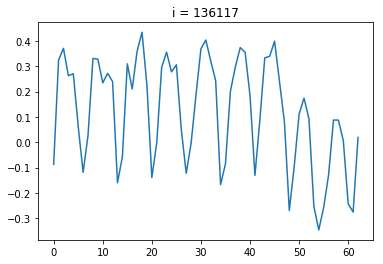

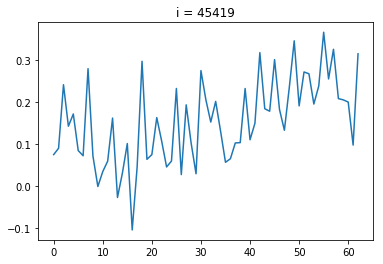

array([135897, 131983,  75806, 136117,  45419])

In [180]:
examine(Y_output_pred)

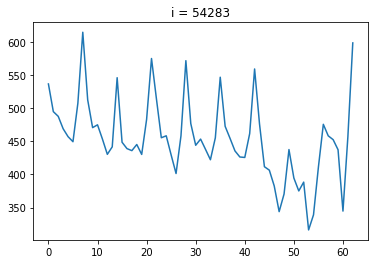

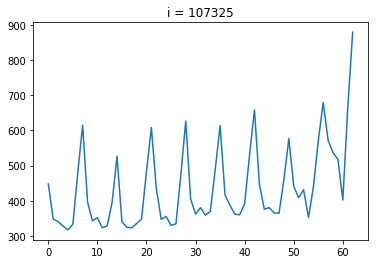

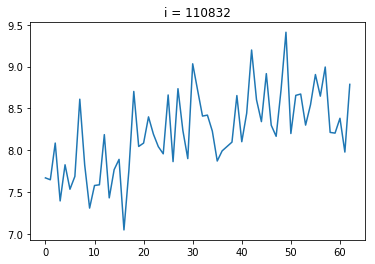

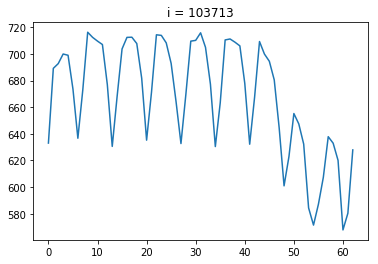

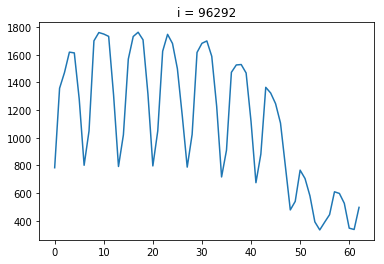

array([ 54283, 107325, 110832, 103713,  96292])

In [181]:
examine(Y_output_pred_ori)

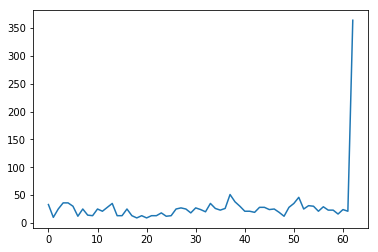

In [182]:
view(X_output_ori[126420])

## Self-Testing

In [183]:
# SMAPE assuming nan == 0
if test_length: 
    model_smape_score_0 = smape(Y_output_ori, Y_output_pred_ori)
    print(model_smape_score_0)

50.1704325988


In [184]:
# SMAPE score excluding nan (Correct one)
if test_length: 
    model_smape_score = smape(Y_output_raw, Y_output_pred_ori)
    print(model_smape_score)

45.9490412399


In [185]:
model_name

'model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days'

In [186]:
epochs_list#, epochs_list2

[40, 40, 40, 40, 60, 80]

## Group Scores
For self-testing stage only

In [187]:
# Prediction Y_output in group
Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]    

In [188]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [189]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [190]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

In [191]:
if test_length: print(count_not_nan(Y_output_raw))

8879607


In [192]:
# Group SMAPE scores
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE assuming nan == 0
    gp_smape_0 = [smape(Y, Y_p) for Y, Y_p 
                  in zip(Y_output_ori_list, Y_output_pred_ori_list)]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape = [smape(Y, Y_p) for Y, Y_p 
                in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    n_not_nan = count_not_nan(Y_output_raw)
    n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
                          in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [193]:
if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape_score, '%6.2f' % model_smape_score_0)

[Group SMAPE]
W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio
187.70 190.56          2.05   3422          0.450
 63.90  74.52          9.63  23105          0.919
 45.06  45.76         12.81  40264          0.995
 38.72  39.05         21.23  77416          0.998
 39.88  45.24          0.22    790          0.965
 30.40  38.01          0.01     66          0.955
-------------------------------------------------
 45.95  50.17


In [194]:
n_not_nan_gp

[96946, 1338299, 2525136, 4867230, 48027, 3969]

if test_length:
    x_tmp = 0.
    for Y, Y_p in zip(Y_output_ori_list, Y_output_pred_ori_list):
        s_tmp = smape(Y, Y_p) * len(Y)
        print(s_tmp / tot_n)
        x_tmp += s_tmp
    print('SMAPE(0):', '%6.2f' % (x_tmp / tot_n))

#the correct one (excluding nan)
n_not_nan = count_not_nan(Y_output_raw)
x_tmp = 0.
for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list):
    s_tmp = smape(Y, Y_p) * count_not_nan(Y)
    print(s_tmp / n_not_nan)
    x_tmp += s_tmp
x_tmp / n_not_nan

## Compare

Y_input_ori = input_data[:,-y_length:]
X_input_ori = input_data[:,:x_length]
X_output_ori = output_data[:,:x_length]

In [195]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

In [196]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True, xlim=None, ylim=None, yscale='linear'):
    plt.yscale(yscale)
    for x in x_list:
        plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None, xlim=None, ylim=None, yscale='linear'):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i), xlim=xlim, ylim=ylim, yscale=yscale)
    return list(view_list)

view_list = None

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

if test_length:
    view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output),
                             view_list=view_list)

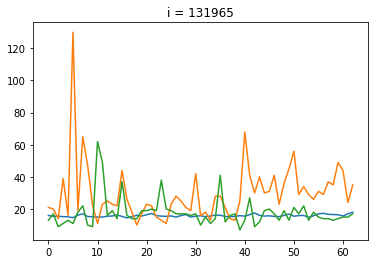

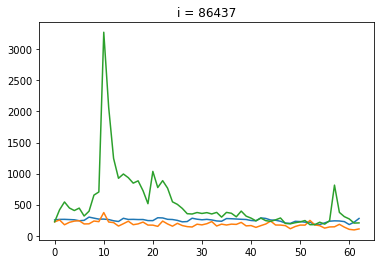

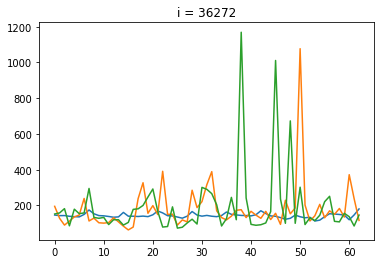

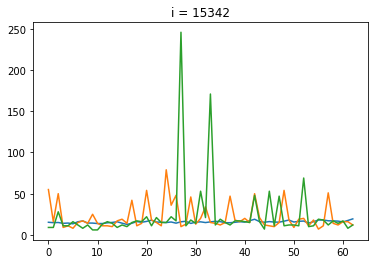

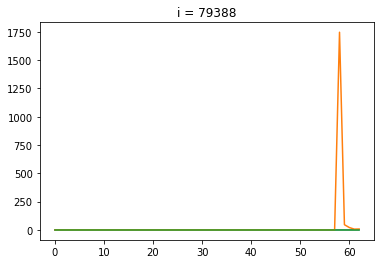

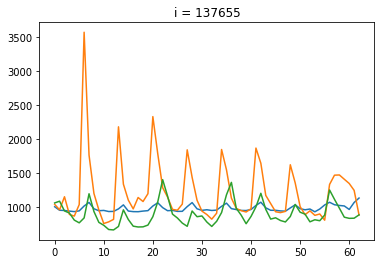

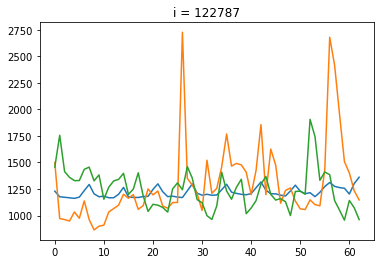

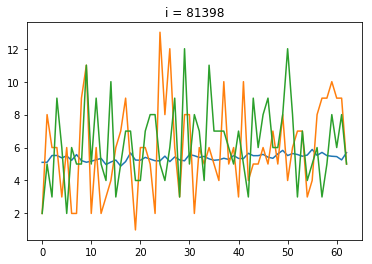

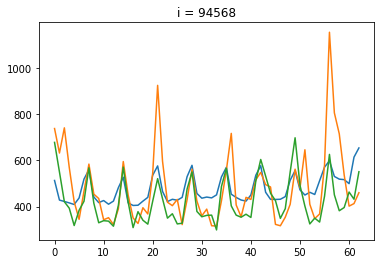

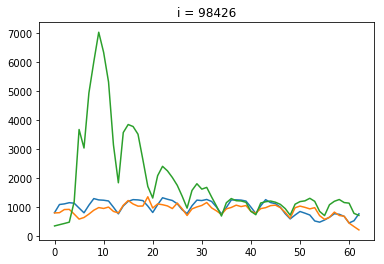

In [197]:
if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
                             view_list=view_list)

comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

In [198]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]; view_list

[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

In [199]:
view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

[90.483912714393767,
 81.647548781463527,
 31.925266644711819,
 173.07748097455914,
 40.931770244977635,
 41.159195428906884,
 15.766211486919429,
 194.80984053284146,
 26.406414672006758,
 22.697543464069021]

In [200]:
view_list_review = [score < model_smape_score for score in view_list_smape]; view_list_review

[False, False, True, False, True, True, True, False, True, True]

In [201]:
view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

[5464, 119659, 64392, 73856, 19234, 25591]

In [202]:
view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

[93175, 13986, 89589, 140331]

#### Good cases

examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
             view_list=view_list_good)

#### Bad cases

examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori),
             view_list=view_list_bad)

In [203]:
print(input_center[view_list_good].reshape(-1))
print(input_center[view_list_bad].reshape(-1))

[ 2.06632593  2.60233134  2.41161971  3.41970798  2.76380222  1.8260748 ]
[ 2.73957234  0.47712125  2.34439227  0.39794001]


In [204]:
output_gp[view_list_good]

array([3, 3, 3, 3, 3, 2])

In [205]:
output_gp[view_list_bad]

array([3, 1, 3, 1])

In [206]:
gp_smape

[187.70102013487977,
 63.898206669501164,
 45.059405327385562,
 38.7243568569735,
 39.884156678990365,
 30.401789504854925]

In [207]:
gp_n

[3422, 23105, 40264, 77416, 790, 66]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

input_center[i], output_center[i], input_scale[i], output_scale[i]

### SMAPE Distribution Investigation

#### SMAPE of the model for each data

In [208]:
if test_length:
    smape_Y_pred_na = np.array([smape(yp, y) for yp, y 
                                in zip(Y_output_pred_ori, Y_output_raw)])
    smape_Y_pred = np.nan_to_num(smape_Y_pred_na)

c:\python3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


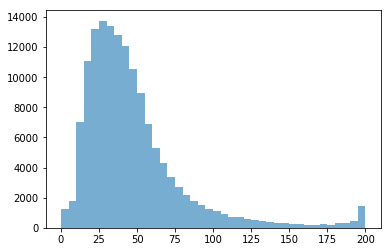

In [209]:
if test_length:
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

In [210]:
if test_length:
    smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]

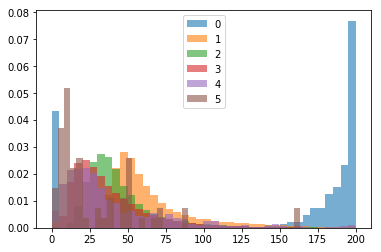

In [211]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.legend()
    plt.show()

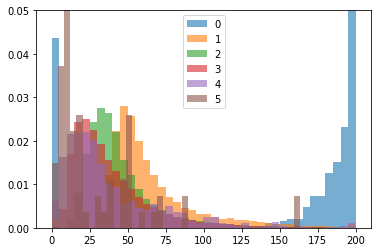

In [212]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

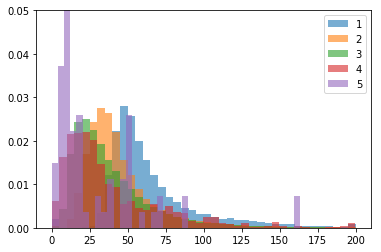

In [213]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    plt.ylim([0,0.05])
    plt.legend()
    plt.show()

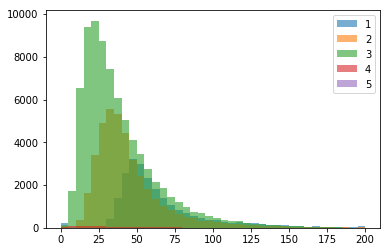

In [214]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list[1:])),smape_Y_pred_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

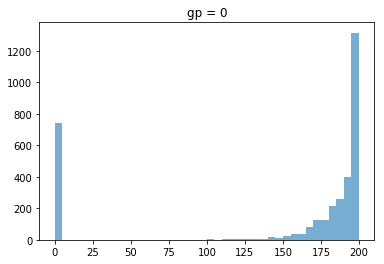

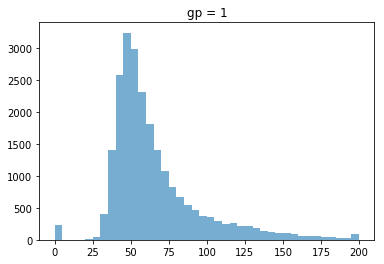

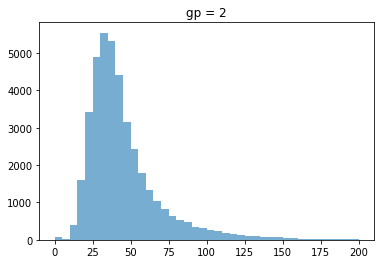

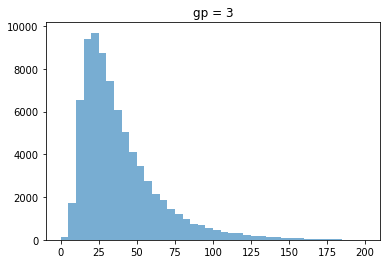

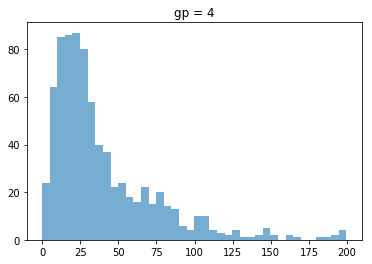

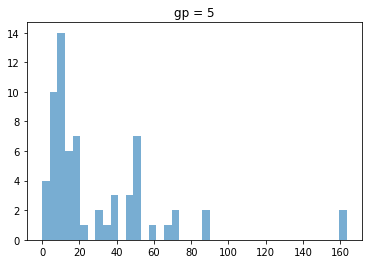

In [215]:
if test_length:
    for i,s in zip(range(len(smape_Y_pred_list)),smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

#### SMAPE for Fibonacci median

What if we replace the group 1 prediction by fib median

In [216]:
Y_output_fib_list = [fib_median[output_gp == gp].reshape(-1,1) 
                     for gp in gp_list]

In [217]:
Y_output_fib_list[1]

array([[ 4.],
       [ 5.],
       [ 4.],
       ..., 
       [ 1.],
       [ 1.],
       [ 4.]])

In [218]:
model_name

'model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days'

In [219]:
# The actual score with nan
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]
    print('Model|', 'Fib|', 'number in the group')
    print('-|-|-')
    for score1, score2, n in zip(gp_smape, gp_smape_fib, gp_n):
        print('%3.3f |'%score1, '%3.3f|'%score2, n)

Model| Fib| number in the group
-|-|-
187.701 | 115.887| 3422
63.898 | 61.823| 23105
45.059 | 45.496| 40264
38.724 | 40.368| 77416
39.884 | 40.033| 790
30.402 | 33.144| 66


See distribution result in '../results/self testing SMAPE distributions.txt'
#### 4
Model| Fib| number in the group
-|-|-
187.701 | 115.887| 3422
63.898 | 61.823| 23105
45.059 | 45.496| 40264
38.724 | 40.368| 77416
39.884 | 40.033| 790
30.402 | 33.144| 66

#### 3
Model| Fib| number in the group
-|-|-
190.248 | 115.887| 3422
63.733 | 61.823| 23105
44.795 | 45.496| 40264
36.303 | 40.368| 77416
41.296 | 40.033| 790
31.296 | 33.144| 66

#### 2
Model| Fib| number in the group
-|-|-
187.272 | 115.887| 3422
64.225 | 61.823| 23105
45.037 | 45.496| 40264
38.056 | 40.368| 77416
40.800 | 40.033| 790
31.231 | 33.144| 66

#### 1
Model| Fib| number in the group
-|-|-
188.348 | 115.887| 3422
64.525 | 61.823| 23105
45.097 | 45.496| 40264
37.586 | 40.368| 77416
40.541 | 40.033| 790
32.286 | 33.144| 66

# **Fib do better in group 0 and 1!!!**

#### SMAPE distribution for Fib

In [220]:
if test_length:
    smape_Y_fib_na = np.array([smape(yp, y) for yp, y 
                               in zip(Y_output_fib, Y_output_raw)])
    smape_Y_fib = np.nan_to_num(smape_Y_fib_na)

    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

c:\python3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


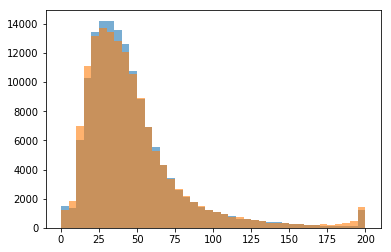

In [221]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6)
    plt.hist(smape_Y_pred, bins=40, alpha=0.6)
    #plt.yscale('log')
    plt.show()

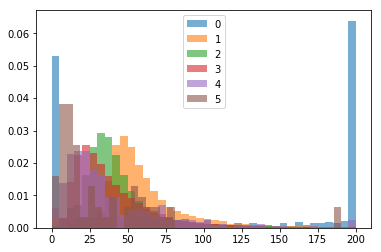

In [222]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label=str(i))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

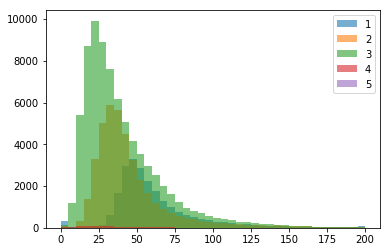

In [223]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list[1:])),smape_Y_fib_list[1:]):
        plt.hist(s, bins=40, alpha=0.6, label=str(i+1))
    #plt.yscale('log')
    #plt.ylim([0,0.05])
    plt.legend()
    plt.show()

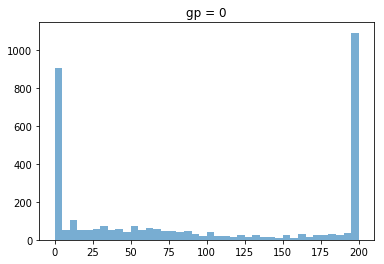

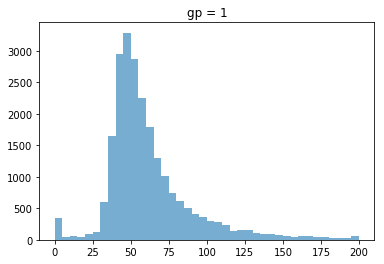

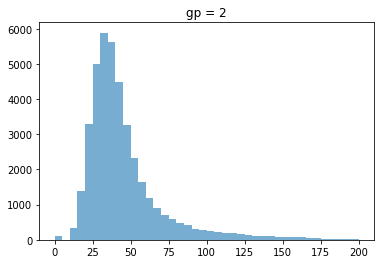

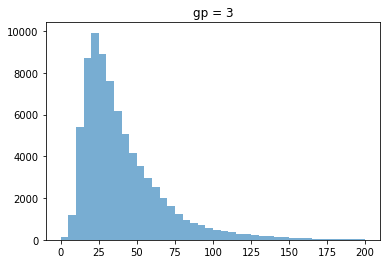

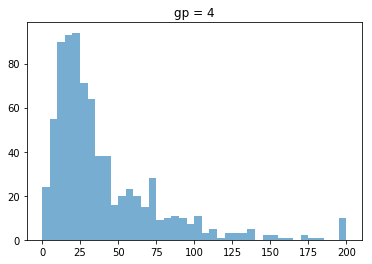

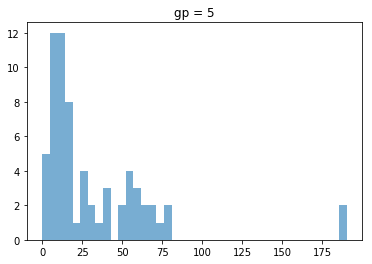

In [224]:
if test_length:
    for i,s in zip(range(len(smape_Y_fib_list)),smape_Y_fib_list):
        plt.hist(s, bins=40, alpha=0.6)
        plt.title('gp = '+str(i))
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Combine
Combine group 0, 1 from Fib and rest from the model

In [225]:
Y_output_fib.shape

(145063, 1)

In [226]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [227]:
# Select group 0, 1
fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [228]:
# The combined result
Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori

In [229]:
Y_output_fmc_ori

array([[ 17.21749669,  17.81038614,  18.08638085, ...,  17.44473498,
         18.38015119,  20.16774517],
       [ 26.18492072,  23.99774643,  23.92493576, ...,  25.57515693,
         29.58504535,  32.37897318],
       [  4.        ,   4.        ,   4.        , ...,   4.        ,
          4.        ,   4.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

#### Combined SMAPE Score

In [230]:
if test_length: 
    model_combined_smape_score = smape(Y_output_fmc_ori, Y_output_raw)
    print('Combined SMAPE (CNN only):', '%6.3f' % model_combined_smape_score, '(%6.3f)' % model_smape_score)

Combined SMAPE (CNN only): 44.852 (45.949)


In [231]:
model_name

'model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days'

See '../results/self testing SMAPE scores.txt' for historical SMAPE scores.

#### Combined Scores:
44.852 (45.949) - Model 8.0.0 - model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days 4

43.458 (44.558) - Model 8.0.0 - model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days 3

44.485 (45.626) - Model 8.0.0 - model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days 2

44.243 (45.442) - Model 8.0.0 - model_8_ANN_with_Fibonacci_0_FC120x3_0_63_days 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool

44.835 (45.961) - Model 7.6.0 - model_7_CNN_with_Fibonacci_6_Wider_0_conv_120 1

44.713 (45.947) - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial 2

44.433          - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial 1

44.168          - Model 7.2.0

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [232]:
Y_output_dates

Index(['2016-10-30', '2016-10-31', '2016-11-01', '2016-11-02', '2016-11-03',
       '2016-11-04', '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
       '2016-11-09', '2016-11-10', '2016-11-11', '2016-11-12', '2016-11-13',
       '2016-11-14', '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
       '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2016-11-28',
       '2016-11-29', '2016-11-30', '2016-12-01', '2016-12-02', '2016-12-03',
       '2016-12-04', '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
       '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object')

In [233]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_pred_ori, columns = Y_output_dates)
result_df

NameError: name 'result_df' is not defined

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                + '.csv', index = False)
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]